<a href="https://colab.research.google.com/github/Daniel-S0ng/RSNA-Challenge-on-Pneumonia-Detection-/blob/main/RSNA_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/dataset/RSNA_Pneumonia/rsna-pneumonia-detection-challenge.zip -d /content/RSNA_dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/RSNA_dataset/stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: /content/RSNA_dataset/stage_2_train_images/d5

In [3]:
!pip install pydicom
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
# from torchvision import transforms
from torch.utils import data

import timm
model_names = timm.list_models()
print(model_names)

['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

In [5]:
label_data = pd.read_csv('/content/RSNA_dataset/stage_2_train_labels.csv')
columns = ['patientId', 'Target']

label_data = label_data.filter(columns)
label_data.head(10)


,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1
5,00436515-870c-4b36-a041-de91049b9ab4,1
6,00569f44-917d-4c86-a842-81832af98c30,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,1


Split into train and val set

In [6]:
train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [7]:
#print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')

In [8]:

train_f = '/content/RSNA_dataset/stage_2_train_images'
test_f = '/content/RSNA_dataset/stage_2_test_images'


train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]

print(f"Training path: {len(train_paths)}")
print(f"Validation path: {len(val_paths)}")

Training path: 27204
Validation path: 3023


In [9]:
# transforms = torch.nn.Sequential(
#     transforms.CenterCrop(10),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# )
# scripted_transforms = torch.jit.script(transforms)

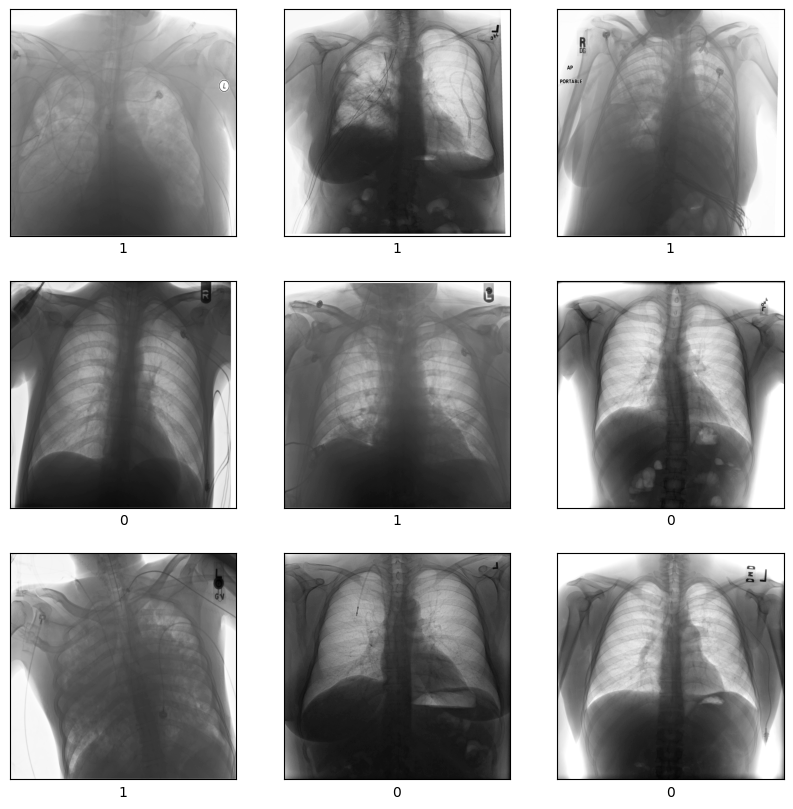

In [10]:
def imshow(num_to_show=9):

    plt.figure(figsize=(10,10))

    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

imshow()

In [11]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(112),
    transforms.ToTensor()])

In [12]:
class Dataset(data.Dataset):

    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        label = self.labels[index][1]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):

        return len(self.paths)

Tensor:tensor([[[0.1608, 0.0863, 0.0784,  ..., 0.0824, 0.0824, 0.0824],
         [0.1529, 0.0863, 0.0784,  ..., 0.0824, 0.0824, 0.0824],
         [0.1490, 0.0863, 0.0784,  ..., 0.0824, 0.0824, 0.0824],
         ...,
         [0.8196, 0.7725, 0.7333,  ..., 0.1294, 0.1176, 0.1059],
         [0.8196, 0.7804, 0.7451,  ..., 0.6667, 0.6706, 0.6784],
         [0.8431, 0.8118, 0.7882,  ..., 0.8353, 0.8471, 0.8627]],

        [[0.1608, 0.0863, 0.0784,  ..., 0.0824, 0.0824, 0.0824],
         [0.1529, 0.0863, 0.0784,  ..., 0.0824, 0.0824, 0.0824],
         [0.1490, 0.0863, 0.0784,  ..., 0.0824, 0.0824, 0.0824],
         ...,
         [0.8196, 0.7725, 0.7333,  ..., 0.1294, 0.1176, 0.1059],
         [0.8196, 0.7804, 0.7451,  ..., 0.6667, 0.6706, 0.6784],
         [0.8431, 0.8118, 0.7882,  ..., 0.8353, 0.8471, 0.8627]],

        [[0.1608, 0.0863, 0.0784,  ..., 0.0824, 0.0824, 0.0824],
         [0.1529, 0.0863, 0.0784,  ..., 0.0824, 0.0824, 0.0824],
         [0.1490, 0.0863, 0.0784,  ..., 0.0824, 0.0

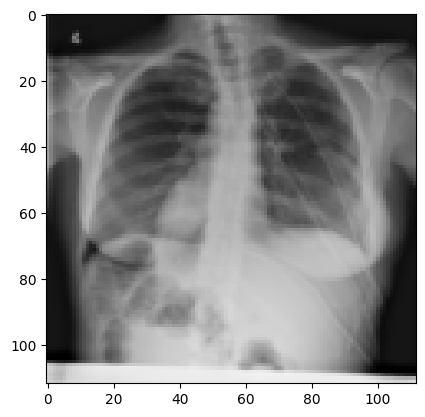

In [13]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
img, label = next(image)
print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

In [14]:
img.shape

torch.Size([112, 112, 3])

In [15]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

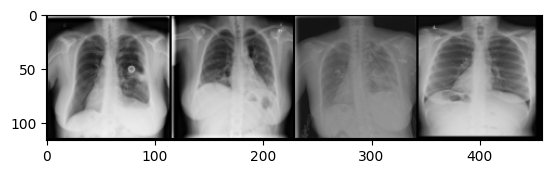

In [16]:
batch = iter(train_loader)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
device

device(type='cuda')

In [19]:
#model = torchvision.models.resnet50(pretrained=True)
model = timm.create_model('tf_efficientnetv2_s', pretrained=True, num_classes=2)
print(model)

#num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

# model.fc = nn.Linear(num_ftrs, 2)
# model.fc = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(num_ftrs, 2)
# )

model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
   

In [20]:
for n,m in model.named_modules():
  print(m)

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
   

In [21]:
#from torchsummary import summary
#summary(model)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
   

In [ ]:
num_epochs = 20
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct_train = 0
    total_train = 0
    # Training step

    for i, (images, labels) in tqdm(enumerate(train_loader)):
        torch.cuda.empty_cache() #added for gpu memory issue
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass

        outputs = model(images)
        loss = criterion(outputs, labels)

        # # Calculate training accuracy for this batch
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (labels == predicted_train).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (i) % 128 == 0:

        #     print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
        #            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Print training accuracy
    print(f'Epoch: {epoch+1}/{num_epochs}, Train_Acc:{100*correct_train/total_train:.2f}%')

    # Validation step
    correct = 0
    total = 0
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()

    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total:.2f}%')



805it [10:23,  1.27it/s]

# New Section

In [ ]:
model.eval()

correct = 0
total = 0
for images, labels in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100*correct/total}')